# Watson Text Analysis

## Table of Contents

- [Import Libraries](#import)
- [Data Cleaning](#data)

<a id ="import"></a>
# Import Libraries

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re, string, unicodedata
from pandas import DataFrame
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/contradictory-my-dear-watson/test.csv
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv


In [12]:
train = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [13]:
test = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


<a id = "data"></a>
# Data Cleaning

In [27]:
train.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [26]:
test.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

In [16]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    #words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [18]:
vocabulary = []
new_train = []
for text in train['premise']:
    new_text = preprocess(text)
    vocabulary.append(new_text)
    new_train.append(' '.join(new_text))

In [19]:
final_train = DataFrame(new_train,columns=['text'])
final_train['id'] = train['id']
final_train['label'] = train['label']
final_train.head()

,text,id,label
0,comments considered formulating interim rules,5130fd2cb5,0
1,issues wrestle practice groups law firms said,5b72532a0b,2
2,des petites choses comme cellesla font une dif...,3931fbe82a,0
3,know ca nt really defend like somebody grown u...,5622f0c60b,0
4,,86aaa48b45,1


In [22]:
final_train['text'].replace('', np.nan, inplace=True)
final_train.dropna(subset=['text'], inplace=True)
final_train.head()

,text,id,label
0,comments considered formulating interim rules,5130fd2cb5,0
1,issues wrestle practice groups law firms said,5b72532a0b,2
2,des petites choses comme cellesla font une dif...,3931fbe82a,0
3,know ca nt really defend like somebody grown u...,5622f0c60b,0
5,bir ciftlikte birisinin agla kapatlms bu okuzl...,ed7d6a1e62,0


<a id = "visual"></a>
# Visualizations

In [24]:
tokens = [item for sublist in vocabulary for item in sublist]
print(len(tokens))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

113841


['de',
 'la',
 'uh',
 'nt',
 'know',
 'yeah',
 'ya',
 'one',
 'like',
 'en',
 'would',
 'que',
 'well',
 'na',
 'think',
 'new',
 'el',
 'un',
 'et',
 'cua',
 'also',
 'wa',
 'two',
 'time',
 'le',
 'really',
 'va',
 'kwa',
 'die',
 'und',
 'oh',
 'les',
 'right',
 'co',
 'um',
 'could',
 'good',
 'get',
 'said',
 'people',
 'es',
 'mot',
 'der',
 'bir',
 'se',
 'years',
 'even',
 'des',
 'du',
 'going']

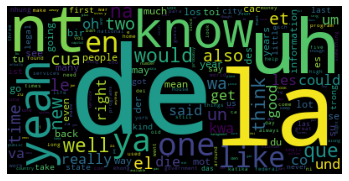

In [25]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<a id = "submission"></a>
# Submission

In [ ]:
X_train = final_train.loc[:7613, 'text'].values
y_train = final_train.loc[:7613, 'target'].values
X_test = final_test.loc[:3263, 'text'].values

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

In [ ]:
predicted = clf.predict(test_vectors)
output = pd.DataFrame({'id': test.id, 'target': predicted})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")